In [1]:
import scanpy as sc
from scipy.sparse import csc_matrix, csr_matrix, save_npz
from scipy.io import mmread, mmwrite
import numpy as np
import pandas as pd
from pathlib import Path
from os import path
import seaborn as sns

In [2]:
folder = '/gpfs/gibbs/pi/zhao/yw599/Multiome/data/PBMC/' 
atac_anno = pd.read_csv('%s/ATAC/scATAC_metadata_filtered.csv' % folder, index_col=0)
rna_anno = pd.read_csv('%s/RNA/scRNA_metadata_filtered.csv' % folder, index_col=0)

In [5]:
folder = '/gpfs/gibbs/pi/zhao/xs272/data_preprocess/PBMC'

In [10]:
count = mmread('%s/RNA/counts.mtx' % folder)
adata_rna = sc.AnnData(count.tocsr())
del count
adata_rna.obs_names = pd.read_table('%s/RNA/cells.txt' % folder, header = None)[0].tolist()
adata_rna.var_names = pd.read_table('%s/RNA/genes.txt' % folder, header = None)[0].tolist()
adata_rna = adata_rna[rna_anno.index].copy()
adata_rna.obs = rna_anno

In [16]:
count = mmread('%s/ATAC_gene_activities/counts_.mtx' % folder)
adata_ga = sc.AnnData(count.tocsr())
del count
adata_ga.obs_names = pd.read_table('%s/ATAC_gene_activities/cells.txt' % folder, header = None)[0].tolist()
adata_ga.var_names = pd.read_table('%s/ATAC_gene_activities/genes.txt' % folder, header = None)[0].tolist()
adata_ga = adata_ga[atac_anno.index].copy()
adata_ga.obs = atac_anno

In [19]:
adata_rna.shape

(14772, 20287)

In [17]:
adata_ga.shape

(8357, 23200)

In [18]:
atac_anno.shape

(8357, 10)

In [29]:
def simMatrix(adata, normalize=True, log=True, hvgs=2000, npcs=30, cell_type='annotation'):
    if normalize:
        sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    if log:
        sc.pp.log1p(adata)
    if hvgs:
        sc.pp.highly_variable_genes(adata, n_top_genes=hvgs)
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca_variance_ratio(adata, log=True)
    sc.pp.neighbors(adata, n_pcs=npcs)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=[cell_type], legend_loc='on data')
    sc.tl.paga(adata, groups=cell_type)
    sc.pl.paga(adata, color=[cell_type])
    pos = adata.uns['paga']['pos']
    D = np.zeros((pos.shape[0], pos.shape[0]))
    for i in range(D.shape[0]-1):
        for j in range(i+1,D.shape[0]):
            D[i,j] = (((pos[i,]-pos[j,])**2).sum())**.5
    D = D+D.transpose()
    ct = adata.obs[cell_type].cat.categories.tolist()
    sim = pd.DataFrame(np.exp(-D), index=ct, columns=ct)
    return sim

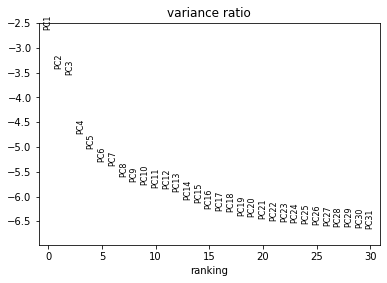

2022-08-04 00:03:36.321793: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ysm-gpfs/apps/software/GCCcore/10.2.0/lib64:/ysm-gpfs/apps/software/GCCcore/10.2.0/lib:/ysm-gpfs/apps/software/R/4.0.3-foss-2020b/lib64/R/lib:/ysm-gpfs/apps/software/R/4.0.3-foss-2020b/lib64:/ysm-gpfs/apps/software/nodejs/12.19.0-GCCcore-10.2.0/lib:/ysm-gpfs/apps/software/GLPK/4.65-GCCcore-10.2.0/lib:/gpfs/ysm/apps/software/ImageMagick/7.0.10-35-GCCcore-10.2.0/lib:/ysm-gpfs/apps/software/LittleCMS/2.11-GCCcore-10.2.0/lib:/gpfs/ysm/apps/software/JasPer/2.0.26-GCCcore-10.2.0/lib:/ysm-gpfs/apps/software/Ghostscript/9.53.3-GCCcore-10.2.0/lib:/ysm-gpfs/apps/software/Armadillo/10.2.1-foss-2020b/lib64:/ysm-gpfs/apps/software/arpack-ng/3.8.0-foss-2020b/lib:/ysm-gpfs/apps/software/Boost/1.74.0-GCCcore-10.2.0/lib:/ysm-gpfs/apps/software/GSL/2.6-GCCcor

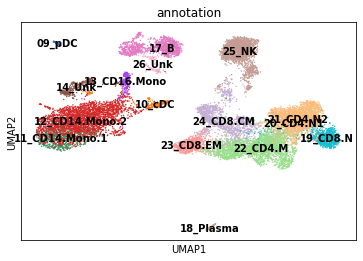

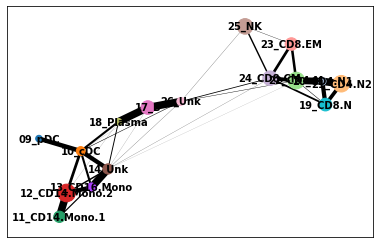

In [30]:
sim_rna = simMatrix(adata_rna)

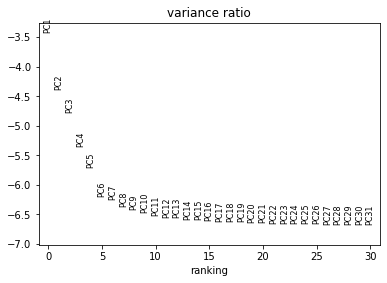

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Group' as categorical
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Barcode' as categorical
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future vers

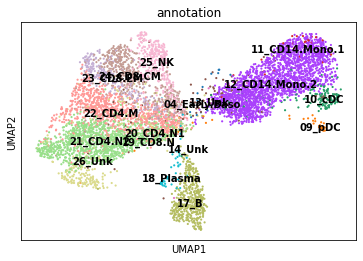

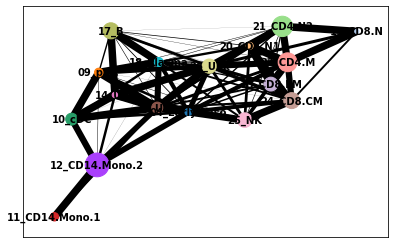

In [31]:
sim_atac = simMatrix(adata_ga)

In [32]:
sim_rna

,09_pDC,10_cDC,11_CD14.Mono.1,12_CD14.Mono.2,13_CD16.Mono,14_Unk,17_B,18_Plasma,19_CD8.N,20_CD4.N1,21_CD4.N2,22_CD4.M,23_CD8.EM,24_CD8.CM,25_NK,26_Unk
09_pDC,1.000000,0.204279,0.045360,0.098717,0.069396,0.063340,0.016228,0.052010,0.000029,0.000028,0.000014,0.000069,0.000053,0.000169,0.000180,0.004812
10_cDC,0.204279,1.000000,0.071258,0.184654,0.235760,0.300427,0.052421,0.169604,0.000118,0.000106,0.000056,0.000258,0.000172,0.000607,0.000482,0.016619
11_CD14.Mono.1,0.045360,0.071258,1.000000,0.385793,0.197073,0.078548,0.005098,0.014462,0.000026,0.000019,0.000011,0.000043,0.000022,0.000091,0.000048,0.001940
12_CD14.Mono.2,0.098717,0.184654,0.385793,1.000000,0.395632,0.172235,0.012204,0.036065,0.000047,0.000037,0.000020,0.000085,0.000048,0.000186,0.000112,0.004381
13_CD16.Mono,0.069396,0.235760,0.197073,0.395632,1.000000,0.397538,0.025235,0.066922,0.000117,0.000091,0.000051,0.000209,0.000112,0.000450,0.000245,0.009840
14_Unk,0.063340,0.300427,0.078548,0.172235,0.397538,1.000000,0.062956,0.156119,0.000259,0.000211,0.000116,0.000491,0.000276,0.001082,0.000616,0.024678
17_B,0.016228,0.052421,0.005098,0.012204,0.025235,0.062956,1.000000,0.303899,0.001603,0.001658,0.000854,0.004186,0.003198,0.010365,0.009067,0.295164
18_Plasma,0.052010,0.169604,0.014462,0.036065,0.066922,0.156119,0.303899,1.000000,0.000540,0.000529,0.000275,0.001322,0.000972,0.003224,0.002840,0.091804
19_CD8.N,0.000029,0.000118,0.000026,0.000047,0.000117,0.000259,0.001603,0.000540,1.000000,0.406373,0.373865,0.245668,0.071919,0.105525,0.015257,0.005306
20_CD4.N1,0.000028,0.000106,0.000019,0.000037,0.000091,0.000211,0.001658,0.000529,0.406373,1.000000,0.501622,0.388255,0.162259,0.149769,0.030036,0.005611


In [33]:
sim_atac

,04_Early.Baso,09_pDC,10_cDC,11_CD14.Mono.1,12_CD14.Mono.2,13_Unk,14_Unk,17_B,18_Plasma,19_CD8.N,20_CD4.N1,21_CD4.N2,22_CD4.M,23_CD8.EM,24_CD8.CM,25_NK,26_Unk
04_Early.Baso,1.000000,0.264021,0.236989,0.075901,0.222319,0.676349,0.383537,0.163793,0.362517,0.076471,0.231519,0.136569,0.214188,0.318756,0.275918,0.492371,0.403843
09_pDC,0.264021,1.000000,0.388389,0.061467,0.173363,0.375077,0.624705,0.448175,0.466174,0.038299,0.146413,0.089157,0.097542,0.119354,0.088097,0.134386,0.255907
10_cDC,0.236989,0.388389,1.000000,0.155290,0.397872,0.341863,0.495684,0.175203,0.218214,0.020734,0.074950,0.043811,0.057097,0.079218,0.065513,0.119418,0.139929
11_CD14.Mono.1,0.075901,0.061467,0.155290,1.000000,0.328181,0.088674,0.088435,0.027549,0.040730,0.006029,0.017760,0.010397,0.016644,0.025754,0.025933,0.051355,0.032367
12_CD14.Mono.2,0.222319,0.173363,0.397872,0.328181,1.000000,0.269242,0.260915,0.078353,0.123473,0.017072,0.053216,0.031015,0.047711,0.072301,0.068370,0.135145,0.097846
13_Unk,0.676349,0.375077,0.341863,0.088674,0.269242,1.000000,0.563824,0.209357,0.420890,0.058156,0.195540,0.113569,0.162387,0.230926,0.190689,0.333017,0.362675
14_Unk,0.383537,0.624705,0.495684,0.088435,0.260915,0.563824,1.000000,0.296329,0.438444,0.040567,0.149667,0.087855,0.109737,0.145618,0.113700,0.189451,0.277612
17_B,0.163793,0.448175,0.175203,0.027549,0.078353,0.209357,0.296329,1.000000,0.434263,0.048823,0.177504,0.121567,0.105288,0.109750,0.075389,0.094529,0.251145
18_Plasma,0.362517,0.466174,0.218214,0.040730,0.123473,0.420890,0.438444,0.434263,1.000000,0.082137,0.314070,0.190028,0.205503,0.237134,0.167118,0.217656,0.535068
19_CD8.N,0.076471,0.038299,0.020734,0.006029,0.017072,0.058156,0.040567,0.048823,0.082137,1.000000,0.261202,0.398989,0.356698,0.234082,0.215357,0.113891,0.145658


<AxesSubplot:>

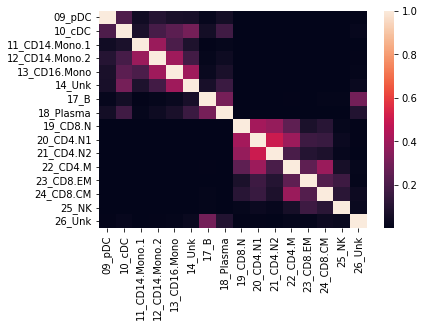

In [34]:
sns.heatmap(sim_rna)

<AxesSubplot:>

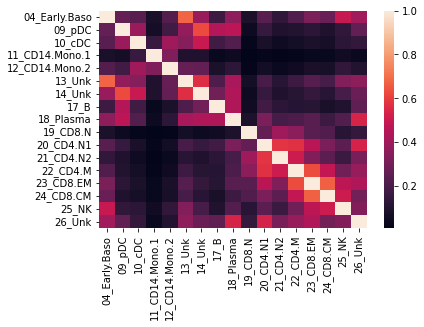

In [35]:
sns.heatmap(sim_atac)

In [36]:
def crossOmicSimMatrix(sim_rna, sim_atac):
    
    ct_rna = sim_rna.index.tolist()
    ct_atac = sim_atac.index.tolist()

    # common cell types
    ct_common = list(set(ct_rna).intersection(ct_atac))

    # rna unique cell types
    ct_rna_only = list(set(ct_rna).difference(ct_atac))

    # atac unique cell types
    ct_atac_only = list(set(ct_atac).difference(ct_rna))
    
    sim = np.zeros((len(ct_atac), len(ct_rna)))
    
    # common to common
    sim[:len(ct_common), :len(ct_common)] = (sim_rna.loc[ct_common, ct_common] + sim_atac.loc[ct_common, ct_common])/2
    
    # atac unique to common
    sim[len(ct_common):, :len(ct_common)] = sim_atac.loc[ct_atac_only, ct_common]
    
    # common to rna unique
    sim[:len(ct_common), len(ct_common):] = sim_rna.loc[ct_common, ct_rna_only]
    
    # atac unique to rna unique
    temp1 = sim_atac.loc[ct_atac_only, ct_common]
    temp1[temp1 < 0.5] = 0
    temp2 = sim_rna.loc[ct_common, ct_rna_only]
    denom = (temp1 != 0).sum(1).values.reshape((-1,1))
    sim[len(ct_common):, len(ct_common):] = (temp1.values @ temp2.values) / denom
    
    sim = pd.DataFrame(sim, index = ct_common + ct_atac_only, columns =  ct_common + ct_rna_only).fillna(0)
    
    return sim

In [37]:
sim = crossOmicSimMatrix(sim_rna, sim_atac)

/tmp/ipykernel_26435/3746516461.py:31: RuntimeWarning: invalid value encountered in true_divide
  sim[len(ct_common):, len(ct_common):] = (temp1.values @ temp2.values) / denom


In [38]:
sim

,26_Unk,10_cDC,12_CD14.Mono.2,11_CD14.Mono.1,18_Plasma,24_CD8.CM,25_NK,22_CD4.M,21_CD4.N2,23_CD8.EM,09_pDC,20_CD4.N1,19_CD8.N,17_B,14_Unk,13_CD16.Mono
26_Unk,1.000000,0.078274,0.051113,0.017154,0.313436,0.167382,0.176869,0.197664,0.156485,0.223290,0.130360,0.269657,0.075482,0.273155,0.151145,0.009840
10_cDC,0.078274,1.000000,0.291263,0.113274,0.193909,0.033060,0.059950,0.028677,0.021934,0.039695,0.296334,0.037528,0.010426,0.113812,0.398055,0.235760
12_CD14.Mono.2,0.051113,0.291263,1.000000,0.356987,0.079769,0.034278,0.067629,0.023898,0.015518,0.036175,0.136040,0.026627,0.008559,0.045278,0.216575,0.395632
11_CD14.Mono.1,0.017154,0.113274,0.356987,1.000000,0.027596,0.013012,0.025702,0.008343,0.005204,0.012888,0.053413,0.008889,0.003027,0.016323,0.083491,0.197073
18_Plasma,0.313436,0.193909,0.079769,0.027596,1.000000,0.085171,0.110248,0.103412,0.095151,0.119053,0.259092,0.157299,0.041338,0.369081,0.297281,0.066922
24_CD8.CM,0.167382,0.033060,0.034278,0.013012,0.085171,1.000000,0.308120,0.434036,0.159538,0.442856,0.044133,0.231737,0.160441,0.042877,0.057391,0.000450
25_NK,0.176869,0.059950,0.067629,0.025702,0.110248,0.308120,1.000000,0.178977,0.087908,0.316890,0.067283,0.137202,0.064574,0.051798,0.095034,0.000245
22_CD4.M,0.197664,0.028677,0.023898,0.008343,0.103412,0.434036,0.178977,1.000000,0.350143,0.436694,0.048805,0.479685,0.301183,0.054737,0.055114,0.000209
21_CD4.N2,0.156485,0.021934,0.015518,0.005204,0.095151,0.159538,0.087908,0.350143,1.000000,0.213119,0.044586,0.541014,0.386427,0.061210,0.043985,0.000051
23_CD8.EM,0.223290,0.039695,0.036175,0.012888,0.119053,0.442856,0.316890,0.436694,0.213119,1.000000,0.059704,0.312521,0.153000,0.056474,0.072947,0.000112


<AxesSubplot:>

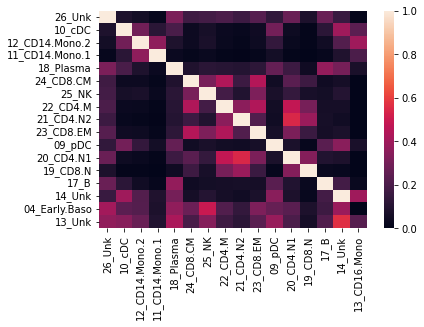

In [39]:
sns.heatmap(sim)

In [40]:
# save
sim.to_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/data/PBMC/sim_PBMC.csv')